# Training a model on CarbonTracker's carbon flux
This notebook outlines the entire workflow to load and preprocess the following data sets, to be able to train a ML model:

- CarbonTracker
- ERA5 (monthly)
- ERA5-land (monthly)
- SPEI (monthly)
- MODIS (monthly)
- Biomass (yearly)
- Copernicus Landcover (yearly)

First follow the data downloading and config setup instuctions.

If you run this notebook on Surf Research Cloud, you shouldn't need to do this anymore.

We start by setting up a Dask client. This will ensure that Dask can run efficiently to process the data:

In [1]:
from dask.distributed import Client
client = Client()

In [2]:
import excited_workflow
from pathlib import Path
import xarray as xr
import xarray_regrid  # Importing this will make Dataset.regrid accessible.

We will load the CarbonTracker data into an xarray `Dataset` and convert the timestamps (middle point of each month) to a more standard format (1st day of the month), to allow merging with the other datasets.

In [3]:
ds_cb = xr.open_dataset("/data/volume_2/EXCITED_prepped_data/CT2022.flux1x1-monthly.nc")
ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)

The other datasets can be found using the excited_workflow.source_datasets module:

In [4]:
from excited_workflow.source_datasets import datasets
datasets

{'biomass': <excited_workflow.source_datasets.biomass.Biomass at 0x7feb09488890>,
 'era5_hourly': <excited_workflow.source_datasets.era5.ERA5Hourly at 0x7feb08dd54d0>,
 'era5_monthly': <excited_workflow.source_datasets.era5.ERA5Monthly at 0x7feb08e018d0>,
 'era5_land_monthly': <excited_workflow.source_datasets.era5.ERA5LandMonthly at 0x7feb08dd67d0>,
 'copernicus_landcover': <excited_workflow.source_datasets.land_cover.LandCover at 0x7feb08e01210>,
 'modis': <excited_workflow.source_datasets.modis.Modis at 0x7feb08e00090>,
 'spei': <excited_workflow.source_datasets.spei.Spei at 0x7feb08dd7390>}

We can loop over the desired datasets and merge them into a single xr.Dataset:

In [5]:
desired_data = [
    "biomass",
    "spei",
    "modis",
    "era5_monthly",
    "era5_land_monthly",
    "copernicus_landcover"
]
ds_input = xr.merge(
    [datasets[name].load(freq="monthly", target_grid=ds_cb) for name in desired_data]
)

To limit the analyis to Transcom region 2 (North America) we require the `regions.nc` file:

In [6]:
ds_regions = xr.open_dataset("/data/volume_2/EXCITED_prepped_data/regions.nc")
# Uncomment the next line to preview the region:
#ds_regions["transcom_regions"].where(ds_regions["transcom_regions"]==2).plot()

Now we can merge everything together. From the CarbonTracker file we only require the `bio_flux_opt` variable:

In [7]:
ds_merged = xr.merge([
    ds_cb[["bio_flux_opt"]], 
    ds_regions["transcom_regions"],
    ds_input,
])

To make computations faster and less memory intensive, we can reduce the scope to only North America.

This `.sel` operation reduces the size of the dataset from worldwide to only a rectangular area around North America:

In [8]:
time_region_na = {
    "time": slice("2000-01", "2019-12"),
    "latitude": slice(15, 60),
    "longitude": slice(-140, -55),
}
ds_na = ds_merged.sel(time_region_na)

In [9]:
ds_na = ds_na.compute()

From this North American dataset we can mask the transcom region, and preview the 2m air temperature of ERA5:

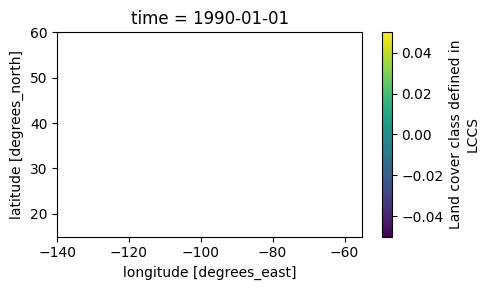

In [10]:
ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
ds_na["lccs_class"].isel(time=0).plot()
plt.tight_layout()

In [11]:
ds_na

<xarray.Dataset>
Dimensions:           (time: 385, latitude: 45, longitude: 85)
Coordinates:
  * longitude         (longitude) float64 -139.5 -138.5 -137.5 ... -56.5 -55.5
  * latitude          (latitude) float64 15.5 16.5 17.5 18.5 ... 57.5 58.5 59.5
  * time              (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2022-01-01
Data variables: (12/26)
    bio_flux_opt      (time, latitude, longitude) float64 nan nan ... nan nan
    transcom_regions  (latitude, longitude) float64 nan nan nan ... nan nan nan
    biomass           (time, latitude, longitude) float64 nan nan ... nan nan
    spei              (time, latitude, longitude) float64 nan nan ... nan nan
    NDVI              (time, latitude, longitude) float64 nan nan ... nan nan
    NIRv              (time, latitude, longitude) float64 nan nan ... nan nan
    ...                ...
    stl4              (time, latitude, longitude) float64 nan nan ... nan nan
    swvl1             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl2             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl3             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl4             (time, latitude, longitude) float64 nan nan ... nan nan
    lccs_class        (time, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    averaging_period_length_hours:  744
    email:                          carbontracker.team@noaa.gov
    url:                            http://carbontracker.noaa.gov
    institution:                    NOAA Earth System Research Laboratory
    Conventions:                    CF-1.5
    history:                        Time-stamp: <Orion-login-1.HPC.MsState.Ed...
    NCO:                            netCDF Operators version 4.9.3 (Homepage ...
    version:                        CT2022 1x1 3-hourly fluxes as of 2023-01-...

To prepare the data for training, we convert it to a Pandas `DataFrame`.

In [12]:
import numpy as np
import pandas as pd
import pycaret.regression

df_train = ds_na.to_dataframe().dropna()
bins = 5
splits = np.array_split(df_train, bins)
for i in range(len(splits)):
    splits[i]['group'] = i + 1
    
df_train = pd.concat(splits)

df = df_train[df_train["group"] != 2]

In [13]:
X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt", "stl1", "swvl1", "lccs_class"]
y_key = "bio_flux_opt"

In [14]:
def train_model(df, X_keys, y_key):
    df_pycaret = df[X_keys + [y_key]]
    df_reduced = df_pycaret[::10]

    df_reduced[y_key] = df_reduced[y_key]*1e6  # So RMSE etc. are easier to interpret.

    pycs = pycaret.regression.setup(df_reduced, target=y_key)

    return pycs

In [15]:
all_pycs = train_model(df_train, X_keys, y_key)
all_best = all_pycs.compare_models(n_select=5, round=2)

,Description,Value
0,Session id,6075
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(26656, 13)"
4,Transformed data shape,"(26656, 13)"
5,Transformed train set shape,"(18659, 13)"
6,Transformed test set shape,"(7997, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.32,0.25,0.50,0.75,0.23,4.42,1.27
rf,Random Forest Regressor,0.33,0.26,0.51,0.74,0.23,4.46,4.59
lightgbm,Light Gradient Boosting Machine,0.33,0.26,0.50,0.74,0.23,4.44,0.14
gbr,Gradient Boosting Regressor,0.35,0.28,0.53,0.72,0.24,4.99,2.15
ridge,Ridge Regression,0.46,0.43,0.65,0.57,0.30,7.98,0.01
br,Bayesian Ridge,0.46,0.43,0.65,0.57,0.30,8.14,0.02
lar,Least Angle Regression,0.48,0.46,0.67,0.55,0.31,8.70,0.02
ada,AdaBoost Regressor,0.50,0.45,0.67,0.55,0.32,9.13,0.50
dt,Decision Tree Regressor,0.47,0.52,0.72,0.48,0.32,6.32,0.10
lr,Linear Regression,0.50,0.54,0.73,0.46,0.32,8.39,0.21


Now we can our ML models on the data. Here we use pycaret to try a set of models and see which type performs best.

In [16]:
one_pycs = train_model(df, X_keys, y_key)
one_best = all_pycs.compare_models(n_select=5, round=2)

,Description,Value
0,Session id,583
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(21325, 13)"
4,Transformed data shape,"(21325, 13)"
5,Transformed train set shape,"(14927, 13)"
6,Transformed test set shape,"(6398, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.32,0.25,0.50,0.75,0.23,4.42,1.28
rf,Random Forest Regressor,0.33,0.26,0.51,0.74,0.23,4.46,5.00
lightgbm,Light Gradient Boosting Machine,0.33,0.26,0.50,0.74,0.23,4.44,0.08
gbr,Gradient Boosting Regressor,0.35,0.28,0.53,0.72,0.24,4.99,2.45
ridge,Ridge Regression,0.46,0.43,0.65,0.57,0.30,7.98,0.02
br,Bayesian Ridge,0.46,0.43,0.65,0.57,0.30,8.14,0.02
lar,Least Angle Regression,0.48,0.46,0.67,0.55,0.31,8.70,0.02
ada,AdaBoost Regressor,0.50,0.45,0.67,0.55,0.32,9.13,0.55
dt,Decision Tree Regressor,0.47,0.52,0.72,0.48,0.32,6.32,0.10
lr,Linear Regression,0.50,0.54,0.73,0.46,0.32,8.39,0.01


2023-11-27 14:11:09,750 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-27 14:11:10,206 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-11-27 14:11:10,636 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-11-27 14:11:10,989 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-11-27 14:11:11,439 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-11-27 14:11:11,931 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-11-27 14:11:12,376 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-11-27 14:11:12,818 - distributed.utils_perf - WARNING - full garbage collections took

Using pycaret, the trained models can be evaluated.

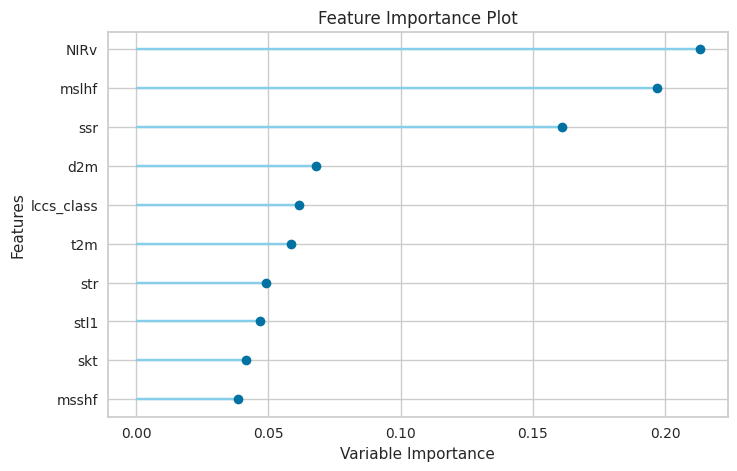

2023-11-27 14:13:05,827 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


In [17]:
all_pycs.plot_model(all_best[0], plot="feature")

By including biomass info, we get a slightly better model performance.

In [21]:
X_keys = ["biomass", "d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt", "stl1", "swvl1", "lccs_class"]
y_key = "bio_flux_opt"

biomass_pycs = train_model(df, X_keys, y_key)
biomass_best = biomass_pycs.compare_models(round=2)

,Description,Value
0,Session id,8199
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(21325, 14)"
4,Transformed data shape,"(21325, 14)"
5,Transformed train set shape,"(14927, 14)"
6,Transformed test set shape,"(6398, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.32,0.24,0.49,0.77,0.22,3.37,1.02
lightgbm,Light Gradient Boosting Machine,0.32,0.24,0.49,0.76,0.23,3.74,0.09
rf,Random Forest Regressor,0.33,0.25,0.50,0.76,0.23,3.65,4.47
gbr,Gradient Boosting Regressor,0.35,0.27,0.52,0.73,0.24,4.59,1.96
ridge,Ridge Regression,0.45,0.42,0.65,0.58,0.29,6.89,0.02
ada,AdaBoost Regressor,0.49,0.42,0.65,0.58,0.31,11.33,0.39
br,Bayesian Ridge,0.46,0.43,0.66,0.57,0.30,7.45,0.01
dt,Decision Tree Regressor,0.47,0.51,0.72,0.49,0.32,6.58,0.10
lr,Linear Regression,0.50,0.54,0.74,0.46,0.32,9.12,0.03
lasso,Lasso Regression,0.51,0.58,0.76,0.43,0.33,8.24,0.02


2023-11-27 14:15:29,819 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-11-27 14:15:30,266 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-11-27 14:15:30,773 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-11-27 14:15:31,191 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-11-27 14:15:31,599 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-11-27 14:15:32,064 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-11-27 14:15:32,446 - distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
2023-11-27 14:15:32,832 - distributed.utils_perf - WARNING - full garbage collections took

However, in the feature importance plot you can see that the importance of NIRv is now reduced by including biomass info:

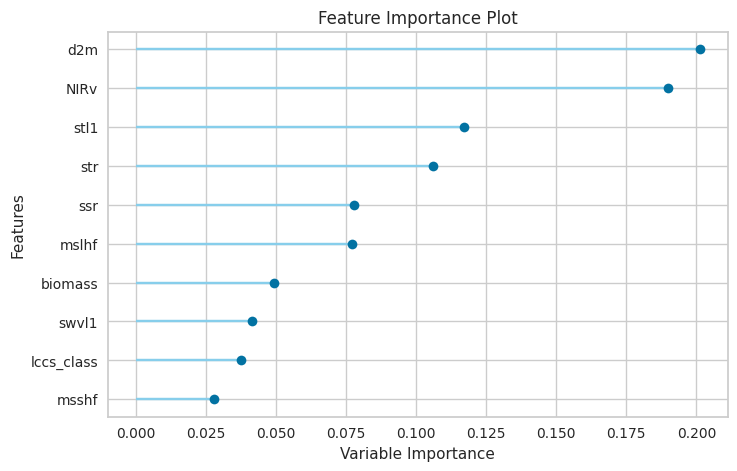

2023-11-27 14:19:09,477 - distributed.utils_perf - WARNING - full garbage collections took 61% CPU time recently (threshold: 10%)


In [22]:
biomass_pycs.plot_model(biomass_best[0], plot="feature")

However, this feature imporance depends on the model used. For a different well performing model, the feature imporance is the following:

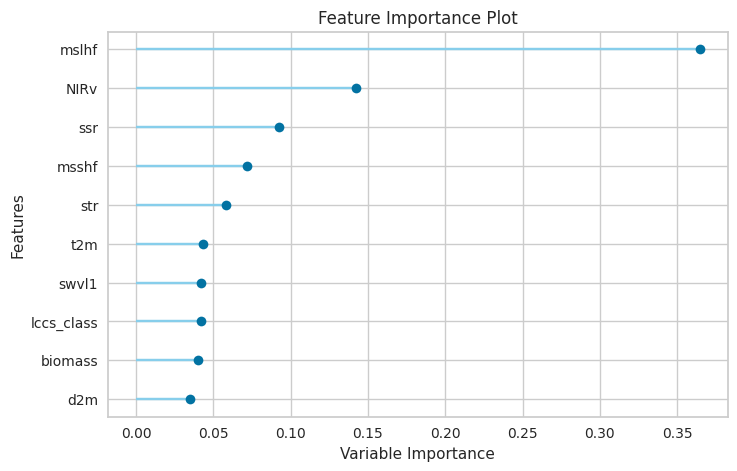

2023-11-27 14:19:18,859 - distributed.utils_perf - WARNING - full garbage collections took 60% CPU time recently (threshold: 10%)


In [23]:
biomass_pycs.plot_model(biomass_best[3], plot="feature")